# **RNN implementation from scratch**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### **Dataset Generation**

In [14]:
# Generate a mapping from integers form their binary representations
seed=42 # randomize the seed as required
np.random.seed(seed)

int2bin = {}
nbits = 8

largest_num = pow(2, nbits)
bin_vals = np.unpackbits(np.array([range(largest_num)],dtype=np.uint8).T,axis=1)
for i in range(largest_num):
  int2bin[i] = bin_vals[i]


**Hyperparameters**

In [15]:
epoch = 20000
lr = 0.1
inp_dim = 2
hidden_dim = 16
out_dim = 1

### **Define the parameters**
define the parameters of the 2-layer network and their respective gradients

In [16]:
# initialize the weights using np random
W_inp_to_h1 = 2*np.random.random((inp_dim,hidden_dim)) - 1
W_h1_to_h2 = 2*np.random.random((hidden_dim,hidden_dim)) - 1
W_h2_to_out = 2*np.random.random((hidden_dim,out_dim)) - 1

# also define np arrays for derivative matrices, these will be used to update the weight parameters every iteration
W_inp_to_h1_grad = np.zeros_like(W_inp_to_h1)
W_h1_to_h2_grad = np.zeros_like(W_h1_to_h2)
W_h2_to_out_grad = np.zeros_like(W_h2_to_out)

**Activation function**

In [17]:
# sigmoid function and its derivative
def sigmoid(x):
    # TODO: implement the sigmoid function
    return 1/(1+np.exp(-x))

def sigmoid_derivative(output):
    # TODO: implement the derivative of the sigmoid function
    return output*(1-output)

### **Training**
The two summands a and b will be represented in binary. The RNN is supposed to generate the binary representation of the output c. Each of a, b and c is represented in 8 bits. In each iteration, one bit of a and one bit of b are passed in pair, and one bit of c is generated. Naturally, the binary representations are traversed from right to left.  
You have to implement BPTT to update the RNN.

In [18]:
allError=[]
Acc = []
# training logic
for j in range(epoch):
    # TODO: sample two summands a and b [make sure they are not too large, the output should be less than largest_num]
    '''
    a_int =
    b_int =
    '''
    # a_int = b_int = 0
    a_int = np.random.randint(largest_num/2)
    b_int = np.random.randint(largest_num/2)
    a_bin = int2bin[a_int] # binary version of a
    b_bin = int2bin[b_int] # binary version of b

    # ground truth
    c_int = a_int + b_int # int version of c
    c_bin = int2bin[c_int] # binary version of c

    # generate an array d for the best answer given by the machine (binary version)
    d_bin = np.zeros_like(c_bin)
    overallError = 0


    outputlayer_deltas = list()
    hidden_values = list()
    # TODO: init hidden_values, append the first hidden_vector into hidden_values
    hidden_values.append(np.zeros(hidden_dim))
    # moving along the positions in the binary encoding
    for position in range(nbits):
        # TODO: generate input and output , move from right to left
        idxs = nbits - position - 1
        inputs = np.array([[a_bin[idxs], b_bin[idxs]]])
        outputs = np.array([[c_bin[idxs]]])
        # TODO: forward propagation
        hidden_layer = sigmoid(np.dot(inputs, W_inp_to_h1) + np.dot(hidden_values[-1], W_h1_to_h2))
        output_layer = sigmoid(np.dot(hidden_layer, W_h2_to_out))

        # TODO: calculate the loss value, calculate loss gradients
        output_error = outputs.T - output_layer
        outputlayer_deltas.append(output_error * sigmoid_derivative(output_layer)*(-1))
        error = ((output_error)**2)/2
        # TODO: decode estimate
        d_bin[idxs] = np.round(output_layer[0][0])
        # TODO: store hidden layer for BPTT
        hidden_values.append(hidden_layer)

    # generate an array to store the hidden and hidden_delta at t + 1 for BPTT
    future_hidden_delta = np.zeros(hidden_dim)
    future_hidden = np.zeros(hidden_dim)

    # TODO: implement BPTT
    for position in range(nbits):
        X = np.array([[a_bin[position],b_bin[position]]])
        hidden_layer = hidden_values[-position-1]
        prev_hidden = hidden_values[-position-2]


        # TODO: compute the intermediate gradient vectors
        # error at output layer
        outputlayer_delta = outputlayer_deltas[-position-1]

        # error at hidden layer * sigmoid_derivative(future_hidden)
        hidden_delta = (future_hidden_delta.dot(W_h1_to_h2.T)*sigmoid_derivative(future_hidden) + outputlayer_delta.dot(W_h2_to_out.T)) * sigmoid_derivative(hidden_layer)

        # TODO: accumulate the weight gradients, and update future_hidden and future_hidden_delta
        hidden_layer_reshaped = hidden_layer.reshape(-1, 1) 
        output_layer_gradient = hidden_layer_reshaped.dot(outputlayer_delta)
        W_h2_to_out_grad += output_layer_gradient
        prev_hidden_reshaped = prev_hidden.reshape(-1, 1) 
        hidden_layer_gradient = prev_hidden_reshaped.dot(hidden_delta)
        W_h1_to_h2_grad += hidden_layer_gradient
        W_inp_to_h1_grad += X.T.dot(hidden_delta)
        future_hidden_delta = hidden_delta
        future_hidden = hidden_layer
    # TODO: update weights using gradients
    W_inp_to_h1 -= W_inp_to_h1_grad * lr
    W_h1_to_h2 -= W_h1_to_h2_grad * lr
    W_h2_to_out -= W_h2_to_out_grad * lr

    # TODO: remember to zero out the gradients
    W_h2_to_out_grad *= 0
    W_h1_to_h2_grad *= 0
    W_inp_to_h1_grad *= 0

    correct = 0
    wrong = 0
    for i in range(nbits):
        if d_bin[i]==c_bin[i]:
            correct += 1
        else:
            wrong += 1
    accuracy = correct / nbits *100
    overallError = wrong / nbits * 100
    if j%100 == 0:
        Acc.append(accuracy)
        allError.append(overallError)



    # print out result
    if(j %1000 == 0):
        print("epoch",j)
        print("Pred:" , d_bin)
        print("True:" ,c_bin)
        out = 0
        for index,x in enumerate(reversed(d_bin)):
            out += x*pow(2,index)
        print(a_int, " + ",b_int," = ",out)
        print("Error:",overallError)
        print("accuracy =", accuracy,"%")
        print("------------")

epoch 0
Pred: [0 0 0 0 0 0 0 0]
True: [0 1 0 0 0 0 1 0]
51  +  15  =  0
Error: 25.0
accuracy = 75.0 %
------------
epoch 1000
Pred: [0 0 0 0 1 0 1 1]
True: [1 0 1 1 1 1 0 0]
113  +  75  =  11
Error: 75.0
accuracy = 25.0 %
------------
epoch 2000
Pred: [1 1 1 1 1 1 1 1]
True: [1 1 1 0 0 1 0 1]
125  +  104  =  255
Error: 37.5
accuracy = 62.5 %
------------
epoch 3000
Pred: [1 1 1 1 0 1 1 0]
True: [0 1 0 1 0 1 0 0]
82  +  2  =  246
Error: 37.5
accuracy = 62.5 %
------------
epoch 4000
Pred: [0 0 0 0 0 1 1 0]
True: [0 0 1 0 0 0 0 0]
3  +  29  =  6
Error: 37.5
accuracy = 62.5 %
------------
epoch 5000
Pred: [0 1 1 1 0 1 0 0]
True: [1 0 0 0 0 1 1 0]
92  +  42  =  116
Error: 62.5
accuracy = 37.5 %
------------
epoch 6000
Pred: [0 0 1 0 1 0 1 0]
True: [0 0 1 0 1 1 0 0]
37  +  7  =  42
Error: 25.0
accuracy = 75.0 %
------------
epoch 7000
Pred: [1 1 0 0 0 1 0 0]
True: [1 0 0 0 0 1 1 0]
75  +  59  =  196
Error: 25.0
accuracy = 75.0 %
------------
epoch 8000
Pred: [0 1 0 0 1 0 1 1]
True: [0 1 0 0

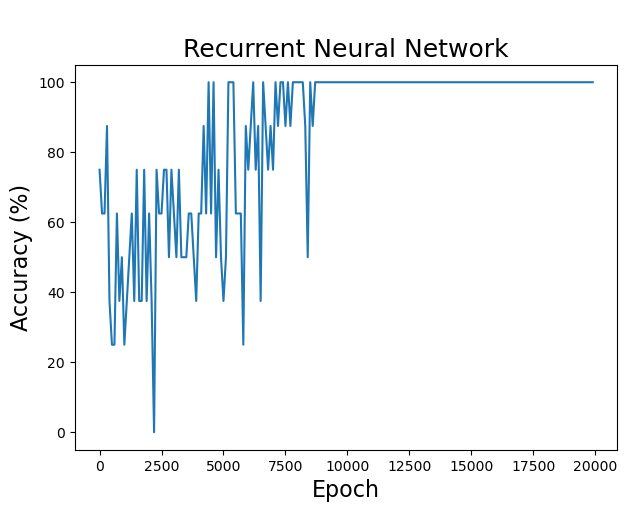

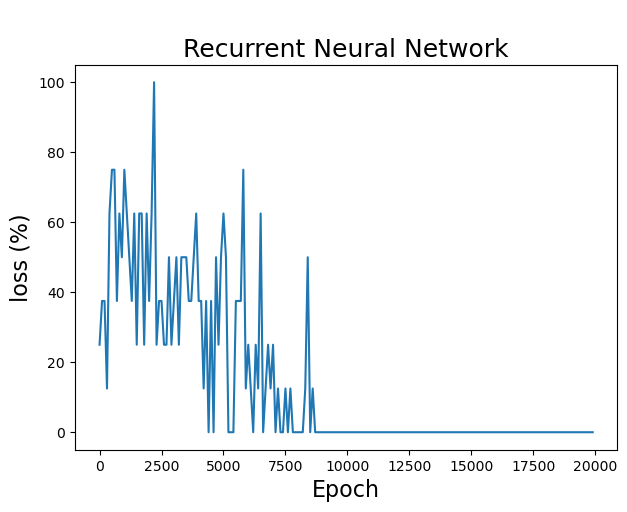

In [19]:
fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,20000,100)
plt.plot(epoch,Acc,linestyle="solid")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=16)
plt.title("\nRecurrent Neural Network",fontsize=18)
plt.show()

fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,20000,100)
plt.plot(epoch,allError,linestyle="solid")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("loss (%)",fontsize=16)
plt.title("\nRecurrent Neural Network",fontsize=18)
plt.show()

In [20]:
# testing for 10 calculation !!!
for i in range(10):
  a_int = np.random.randint(largest_num/2)
  a_bin = int2bin[a_int]
  b_int = np.random.randint(largest_num/2)
  b_bin = int2bin[b_int]

  # true answer
  c_int = a_int + b_int
  c_bin = int2bin[c_int]
  d_bin = np.zeros_like(c_bin)

  hidden_values = list()
  hidden_values.append(np.zeros(hidden_dim))
  # TODO: generate d_bin binary string from a_bin and b_bin
  for position in range(nbits):
      # TODO: your code
      X = np.array([[a_bin[nbits - position - 1],b_bin[nbits - position - 1]]])
      y = np.array([[c_bin[nbits - position - 1]]]).T
      hidden_layer = sigmoid(np.dot(X, W_inp_to_h1) + np.dot(hidden_values[-1], W_h1_to_h2))
      output_layer = sigmoid(np.dot(hidden_layer, W_h2_to_out))
      d_bin[nbits - position - 1] = np.round(output_layer[0][0])
      hidden_values.append(hidden_layer)


  out = 0
  for index,x in enumerate(reversed(d_bin)):
      out += x*pow(2,index)

  print(a_int, " + ",b_int," = ",out)


29  +  34  =  63
20  +  110  =  130
103  +  62  =  165
121  +  91  =  212
102  +  16  =  118
11  +  115  =  126
113  +  17  =  130
124  +  110  =  234
118  +  91  =  209
59  +  66  =  125
